In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from calculations import fret_calculations, processing_cleanup
import matplotlib as mpl
from IPython.display import display
import scipy.stats as stats
from calculations.significance import set_pvalue
import matplotlib.patches as mpatches

In [2]:
df = pd.read_csv(r'D:\OneDrive\Virus\Paper1\Raw_data_CSVs\Infection\new_parameters.csv')

C:\Users\patri\AppData\Local\Temp\ipykernel_35424\1001020355.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:\OneDrive\Virus\Paper1\Raw_data_CSVs\Infection\new_parameters.csv')


In [3]:
comb_df = df

comb_df['construct'] = comb_df['construct'].astype(str)
comb_df['well'] = comb_df['well'].astype(str)
comb_df['experimentcondition'] = comb_df['experimentcondition'].astype(str)

#comb_df.to_csv(r'D:\OneDrive\Virus\Paper1\Raw_data_CSVs\Infection\new_parameters.csv')

In [4]:
columns_to_drop = comb_df.columns
columns_to_drop = columns_to_drop[0:12]
comb_df = comb_df.drop(columns = columns_to_drop)


In [58]:
tmp_df = comb_df.loc[(comb_df['construct']!= 'GS32') & (comb_df['construct']!= 'SED1') &(comb_df['construct']!= 'mTQ2')&(comb_df['construct']!= 'mNG')]
tmp_df = processing_cleanup.pixels_to_micron(tmp_df)
tmp_df = fret_calculations.acceptor_correction(tmp_df)
tmp_df = fret_calculations.calculate_efret(tmp_df)
tmp_df = processing_cleanup.area_cutoffs(tmp_df, lower_cutoff = 550.0, upper_cutoff=7500)
tmp_df = processing_cleanup.remove_maximums(tmp_df, 'directAcceptor')
tmp_df = processing_cleanup.remove_minimums(tmp_df, 'directAcceptor')
tmp_df = processing_cleanup.directacceptor_mean_cutoffs(tmp_df)
tmp_df = processing_cleanup.donor_mean_cutoffs(tmp_df, 450)
mcherry_tmp_df = tmp_df.copy()
tmp_df = processing_cleanup.infection_false_positives(tmp_df)
tmp_df = processing_cleanup.infection_parameters(tmp_df, lower_cutoff = 0.15, upper_cutoff = 0.85)
tmp_df = tmp_df.loc[tmp_df['experimentparameter'] != 'mixed_population']

###
growth_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Growth']

noninfected_only = growth_df.loc[growth_df['experimentparameter'] == 'noninfected']
infect_too = growth_df.loc[growth_df['experimentparameter'] != 'noninfected']

noninfected_only['experimentparameter'] = 'Growth'

###
tmp_df['experimentcondition'] = tmp_df['experimentcondition'].replace('Infection', 'Infect')
infected_df = tmp_df.loc[tmp_df['experimentcondition'] == 'Infect']
###

recom_df = pd.concat([noninfected_only, infected_df])


C:\Users\patri\AppData\Local\Temp\ipykernel_35424\1759989638.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noninfected_only['experimentparameter'] = 'Growth'


In [59]:


constructs = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
experiment_order = ['Infection']
experiment_condition = ['Growth', 'Infection']
experiment_parameter = ['Growth', 'noninfected', 'infected']

my_sort_dict = {
            'construct' : constructs,
            'experiment': experiment_order,
            'experimentcondition': experiment_condition,
            'experimentparameter': experiment_parameter, 
               }

GS32 = recom_df.loc[(recom_df['construct']== 'GS32')]

recom_df = processing_cleanup.sort_values(recom_df, my_sort_dict)
recom_df = recom_df.reset_index(drop=True)
if 'Unnamed: 0.1' in recom_df.columns:
    recom_df = recom_df.drop(columns=['Unnamed: 0.1'])

In [60]:

groupby_values = ['construct', 'experiment', 'experimentcondition', 'experimentparameter',  'timepoint']

filtered_df = processing_cleanup.remove_outliers(recom_df, groupby_values, 'Efret')


In [61]:
#get median stats of the experiment and for the well

groupby_values_per_repeat = ['construct', 'date', 'experiment', 'experimentcondition', 'experimentparameter', 'well', 'timepoint']
groupby_values_per_experiment = ['construct', 'experiment', 'experimentcondition', 'experimentparameter',  'timepoint']

total_stats_df = processing_cleanup.get_stats(filtered_df, groupby_values_per_repeat)
experiment_stats = processing_cleanup.get_stats(filtered_df, groupby_values_per_experiment)
#display(total_stats_df)
test = total_stats_df['Efret_list'].apply(np.array) - total_stats_df['Efret_median']


In [62]:
print(test)

0           [-0.005941464265807106, 0.005941464265806995]
1       [-0.007046007919310093, -0.07404993204422494, ...
2       [0.023261371461388847, -0.04662412415264555, -...
3        [-0.01055480884349902, 0.0, 0.03939451596741328]
4       [-0.011559582513085753, -0.0024926926625505885...
                              ...                        
2736    [0.0050598140597226116, 0.001425013037586076, ...
2737    [-0.0009686313765199794, -0.015204345399860375...
2738    [0.005382542097936316, 0.03860082919074176, -0...
2739    [-0.0018952511054444732, 0.0031166252137949657...
2740    [-0.001779445179979522, 0.009895565374740511, ...
Length: 2741, dtype: object


In [63]:
#population stats
groupby_values_experiment = ['construct', 'experiment', 'experimentcondition',  'timepoint', 'experimentparameter']
holder_df = processing_cleanup.get_population_significance(total_stats_df, groupby_values_experiment)
ttest_df = holder_df.dropna()

In [64]:
new_values =  ['construct', 'experiment', 'experimentcondition', 'experimentparameter', 'timepoint']

population_count_df = processing_cleanup.get_stats(total_stats_df, new_values, ['count'], stat_column='Efret_median')
median_std_df = processing_cleanup.get_stats(total_stats_df, new_values, ['std'], stat_column='Efret_median')
list_efret_df = processing_cleanup.get_stats(total_stats_df, new_values, ['list'], stat_column='Efret_median')
population_count_df = population_count_df.drop(columns=new_values)
median_std_df = median_std_df.drop(columns = new_values)
list_efret_df = list_efret_df.drop(columns = new_values)
population_count_df = population_count_df.rename(columns={'Efret_median_count': 'well_count_per_timepoint'})
median_std_df = median_std_df.rename(columns={'Efret_median_std': 'std_median_per_timepoint'})
list_efret_df = list_efret_df.rename(columns={'Efret_median_std': 'list_median_per_timepoint'})


In [65]:
merged_data = pd.concat([experiment_stats, population_count_df, median_std_df, list_efret_df], axis=1)
#merged_data.to_csv(r'E:\Patrick\Test_data.csv')

merged_data = merged_data.merge(ttest_df, on=['construct', 'experiment', 'experimentcondition', 'experimentparameter', 'timepoint'])

In [72]:
merged_delta = merged_data.copy()

merged_delta = processing_cleanup.delta_time(merged_delta, 'Efret_median', comparison= 4)
merged_delta = processing_cleanup.remove_controls(merged_delta)
merged_delta = processing_cleanup.drop_counts(merged_delta, 20)

merged_delta = processing_cleanup.delta_time(merged_delta, 'Efret_median_list', comparison= 4)



total_df = total_stats_df.copy()

total_df = processing_cleanup.delta_time(total_df, 'Efret_median', comparison= 4)
total_df = processing_cleanup.remove_controls(total_df)


total_df = processing_cleanup.delta_list_median(total_df, merged_delta, 'Efret_list', comparison= 4)

In [73]:
consolidated_values = total_df.groupby(['construct', 'experiment', 'experimentparameter', 'timepoint'], observed=False, as_index=False)['delta_Efret_median'].apply(np.array)
consolidated_values = consolidated_values.loc[(consolidated_values['construct']!= 'mTQ2') & (consolidated_values['construct']!= 'mNG')]
consolidated_values = consolidated_values.dropna().reset_index(drop=True).rename(columns={'delta_Efret_median': 'delta_median_wells'})

merged_delta = merged_delta.merge(consolidated_values, on=['construct', 'experiment', 'experimentparameter', 'timepoint'], how='left')

consolidated_values = total_df.groupby(['construct', 'experiment', 'experimentparameter', 'timepoint'], observed=False, as_index=False)['delta_Efret_list'].apply(np.array)
consolidated_values = consolidated_values.loc[(consolidated_values['construct']!= 'mTQ2') & (consolidated_values['construct']!= 'mNG')]
consolidated_values = consolidated_values.dropna().reset_index(drop=True).rename(columns={'delta_Efret_median': 'delta_Efret_population'})

merged_delta = merged_delta.merge(consolidated_values, on=['construct', 'experiment', 'experimentparameter', 'timepoint'], how='left')


In [74]:
tmpr_df = merged_delta.copy()

construct_order = {c: i + 1 for i, c in enumerate(constructs)}


tmpr_df['base_position'] = tmpr_df['construct'].map(construct_order)

# Step 2: For each unique (construct, experimentparameter) pair, compute a subposition offset.
# This mapping is computed once, so it is consistent across all timepoints.
mapping = {}
for construct, order in construct_order.items():
    
    # Get unique experimentparameters for this construct, preserving order of appearance
    unique_params = pd.unique(tmpr_df.loc[tmpr_df['construct'] == construct, 'experimentparameter'])
    n = len(unique_params)
    # Compute offsets evenly in [-0.5, 0.5] (you can adjust the range as needed)
    offsets = (np.arange(n) - (n-1) / 2) / 4
    for exp, offset in zip(unique_params, offsets):
        mapping[(construct, exp)] = offset

# Step 3: Apply the mapping to assign a subposition to every row.
tmpr_df['subposition_offset'] = tmpr_df.apply(lambda row: mapping[(row['construct'], row['experimentparameter'])], axis=1)

tmpr_df['base_position'] = tmpr_df['base_position'].astype(int)
# Step 4: The final plot position for a row is the sum of its base position and subposition offset.
tmpr_df['plot_position'] = tmpr_df['base_position'] + tmpr_df['subposition_offset']

constructs = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
experiment_order = ['Infection']
experiment_condition = ['Growth', 'Infection']
experiment_parameter = ['Growth', 'noninfected', 'low infection', 'med infection', 'high infection']

my_sort_dict = {
            'construct' : constructs,
            'experiment': experiment_order,
            'experimentcondition': experiment_condition,
            'experimentparameter': experiment_parameter, 
               }


tmpr_df = processing_cleanup.sort_values(tmpr_df, my_sort_dict)

C:\Users\patri\AppData\Local\Temp\ipykernel_35424\1592766757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = (plot_df['timepoint'] * 6)


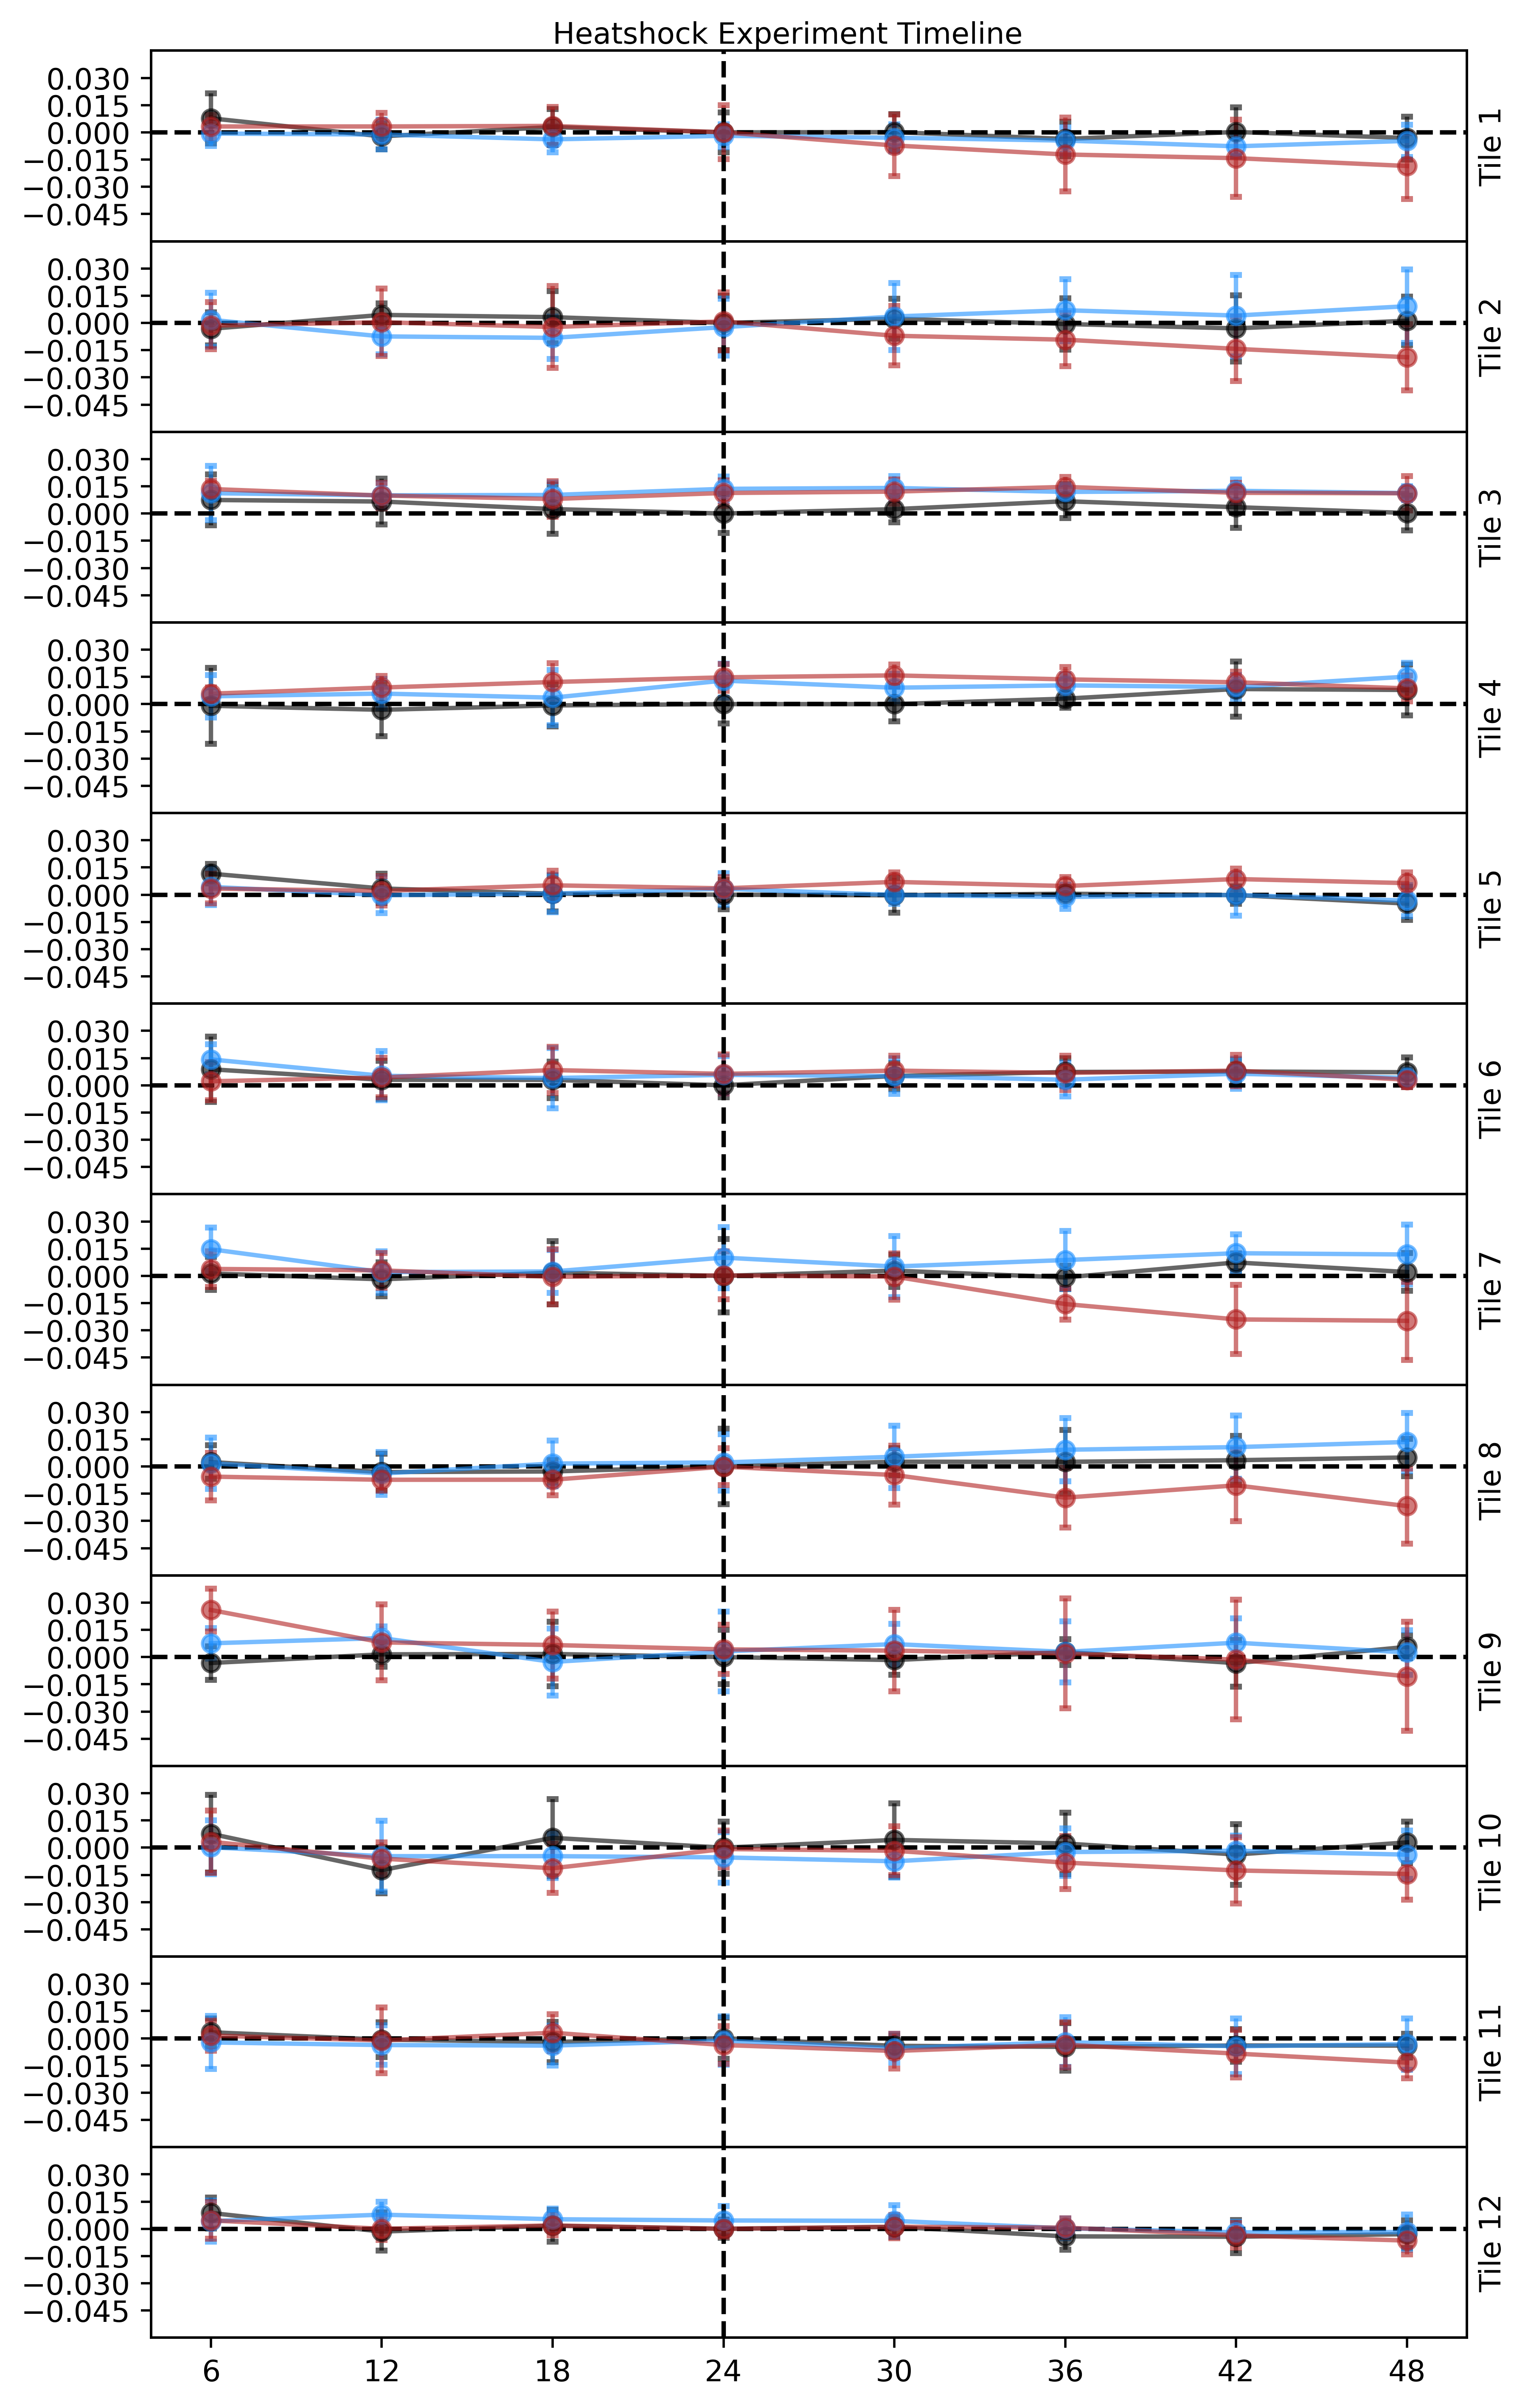

In [83]:
#make time dataplots for each construct
plot_df = tmpr_df.loc[tmpr_df['timepoint']!= 0]
plot_df['timepoint'] = (plot_df['timepoint'] * 6)
generator = plot_df.groupby('construct', observed=True)
mpl.rcParams['figure.dpi'] = 500
fig_len = 12
fig, ax =plt.subplots(fig_len,  1, figsize=(8,14)) 
for index, container in enumerate(generator):
    construct = container[0]
    
    if index < fig_len:
        container_df = container[1]
        
        
        indexer = 0
        colors = ['k', 'dodgerblue', 'firebrick']
        for parameter in container_df.experimentparameter.unique():
            
            current_parameter = container_df.loc[container_df['experimentparameter']== parameter]
            
            
            ax[index].scatter(x=current_parameter['timepoint'], y=current_parameter['delta_Efret_median'], alpha=0.6, c=colors[indexer], zorder=3)
            ax[index].errorbar(current_parameter['timepoint'], current_parameter['delta_Efret_median'], yerr = current_parameter['std_median_per_timepoint'], c=colors[indexer],
                                                    capsize=2, capthick=2, alpha=0.6)
            indexer += 1
        ax[index].set_ylim(-0.06, 0.045)
        ax[index].set_yticks([ -0.045, -0.03, -0.015, 0, 0.015, 0.03])
        ax[index].set_xticks([])
        ax[index].axvline(x=24, c='k', linestyle='--')
        ax[index].axhline(y=0.0, c='k', linestyle='--')
        ax2 = ax[index].twinx()
        ax2.set_yticks([])
        ax2.set_ylabel(ylabel = 'Tile ' + str(construct))

tick_array = np.array(current_parameter['timepoint'])
ax[-1].set_xticks(tick_array)
fig.suptitle('Heatshock Experiment Timeline', fontsize=10, x=0.5, y=0.89)
plt.subplots_adjust(hspace=0)
plt.savefig(r'D:\OneDrive\Virus\Paper1\Paper1_figures\Violin_figures\infection_timeline_figure_percentile-0.15.png', format='png', bbox_inches='tight')

C:\Users\patri\AppData\Local\Temp\ipykernel_35424\3710776520.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_tmp['timepoint'] = new_tmp['timepoint'] * 6


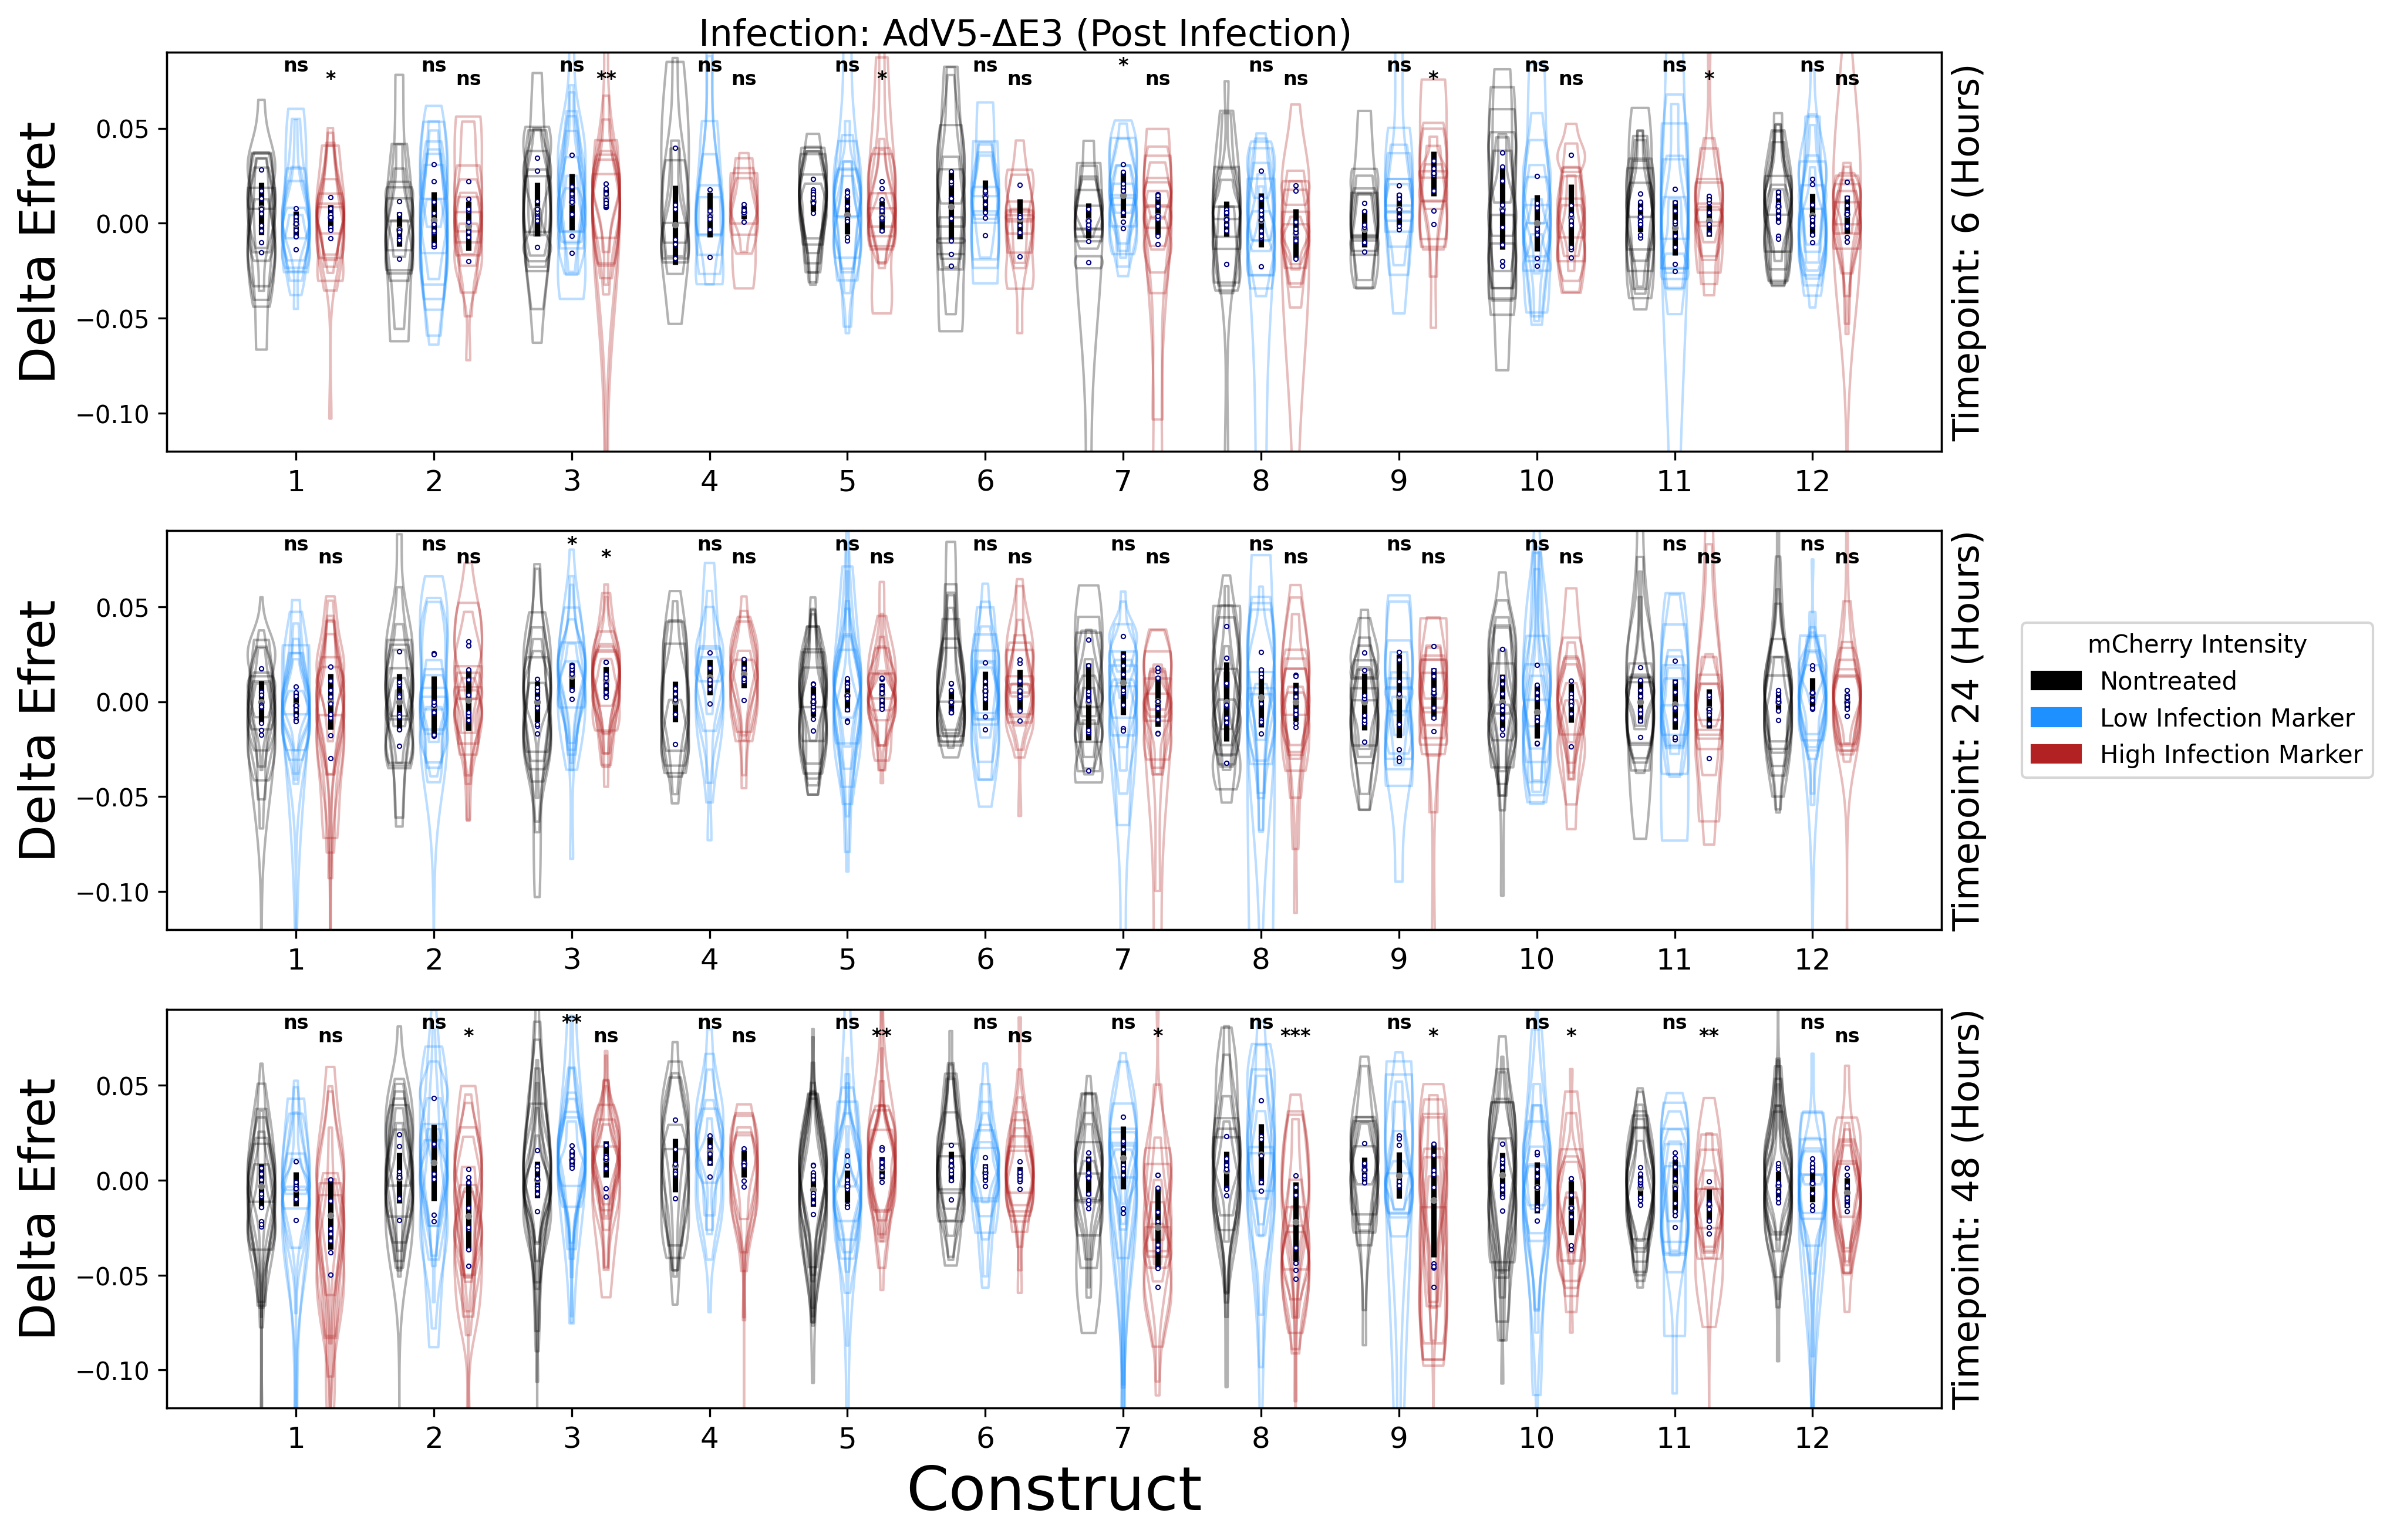

In [81]:
#dataframes are merged_data, experiment_stats, and test_df
replaced_data = tmpr_df
reduced_df = replaced_data.loc[(replaced_data['timepoint']==1) |(replaced_data['timepoint']==4) | (replaced_data['timepoint']==8)]

mpl.rcParams['figure.dpi'] = 300
save_plot = True

unique_parameters = reduced_df.experimentparameter.unique()
color_palette = ['k', 'dodgerblue', 'firebrick', 'brown']
colors = {}

for i, param in enumerate(unique_parameters):
    colors[param] = color_palette[i]

construct = len(reduced_df.construct.unique())
timepoints = len(reduced_df.timepoint.unique())
parameter = len(reduced_df.experimentparameter.unique())
grouped_values = ['timepoint']

uni_construct = reduced_df.construct.unique()
#indexer length
row_len = timepoints

fig, ax = plt.subplots(row_len, 1, figsize=(13,10))

new_tmp = reduced_df
new_tmp['timepoint'] = new_tmp['timepoint'] * 6
median_violin_generator = new_tmp.groupby(grouped_values, observed=True, as_index=True)

for index, container in enumerate(median_violin_generator):
    tmp_df = container[1]
    row = index
    ax[row].scatter(x= tmp_df['plot_position'], y=tmp_df['delta_Efret_median'], s=3, c='gray', zorder=3)
    ax[row].errorbar(x= tmp_df['plot_position'], y=tmp_df['delta_Efret_median'], yerr= tmp_df['std_median_per_timepoint'], linestyle='none', color='k',elinewidth=2.2)
    y=0
    con_holder = None
    for x in tmp_df['plot_position']:
        len_param = tmp_df.experimentparameter.nunique()
        current_construct = tmp_df.loc[tmp_df['plot_position']==x, 'construct'].iloc[0]
        if con_holder is None:
            con_holder = current_construct
            y+=1
            continue
        
        if con_holder != current_construct:
            y=0
            con_holder = current_construct
            y+=1
            continue
        
        if y == len_param:
            y=0
            y+=1
            continue
            
            
        y_pos = 0.087 - y*0.007
        star_val = tmp_df.loc[tmp_df['plot_position']==x, 'star_value']
        ax[row].text(x, y_pos, s=star_val.iloc[0], fontsize=8, fontweight='bold', ha='center')
        y+=1
    ax[row].set_ylim([-0.12, 0.09])
    tmp_explode = tmp_df.explode('delta_Efret_median_list')
    ax[row].scatter(x=tmp_explode['plot_position'] , y=tmp_explode['delta_Efret_median_list'], s=3, c='white', edgecolor='navy', linewidth=0.5, zorder=3)

    tmp_explode = tmp_df.explode('delta_Efret_list')
    
    iterator = 0 
     
    
    
    for x in tmp_df['plot_position']:
        list_explode = tmp_explode.loc[tmp_explode['plot_position']== x]
        current_parameter = tmp_explode.loc[tmp_explode['plot_position']== x, 'experimentparameter'].iloc[0]
        
        len_dataframe = len(list_explode)
        
        len_para = tmp_explode.experimentparameter.nunique()
        if iterator == len_para:
            iterator = 0
        if 'Growth' == current_parameter:
            iterator = 0 
            
        current_color = colors[current_parameter]
        
        for sub in range(len_dataframe):
            current_dataframe = list_explode.iloc[sub]
            
            final_explode = current_dataframe['delta_Efret_list']
            violins =ax[row].violinplot(final_explode, [x], widths=0.2, showextrema=False, showmedians=False, showmeans=False)

            
            for pc in violins['bodies']:
                pc.set_facecolor('None')
                pc.set_edgecolor(current_color)
                pc.set_aplha=0.3

        iterator += 1
    
    ax[row].set_xticks(np.arange(1, construct+1, 1))
    ax[row].set_xticklabels(uni_construct, fontsize='large')


    twinax = ax[row].twinx()
    twinax.set_ylabel('Timepoint: '+ str(container[0][0])+ ' (Hours)', fontsize=15)
    twinax.set_yticks([])

    ax[row].set_ylabel('Delta Efret', fontsize=20)
ax[-1].set_xlabel('Construct', fontsize=25)

patch = []
labels = ['Nontreated', 'Low Infection Marker', 'High Infection Marker']
for color, label in zip(color_palette, labels):
    
    tmp_patch = mpatches.Patch(color=color, label=label)
    patch.append(tmp_patch)
plt.legend(title='mCherry Intensity', handles=patch, loc='upper right', bbox_to_anchor=(1.25, 2))

fig.suptitle('Infection: AdV5-'+'\u0394'+'E3 (Post Infection)', fontsize=15, x=0.5, y=0.9)
if save_plot:
    plt.savefig(r'D:\OneDrive\Virus\Paper1\Paper1_figures\Violin_figures\infection_violinplot_figure_percentile-0.15.png', format='png', bbox_inches='tight')
plt.show()


C:\Users\patri\AppData\Local\Temp\ipykernel_35424\383728635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_only['experimentparameter'] = 'Growth'


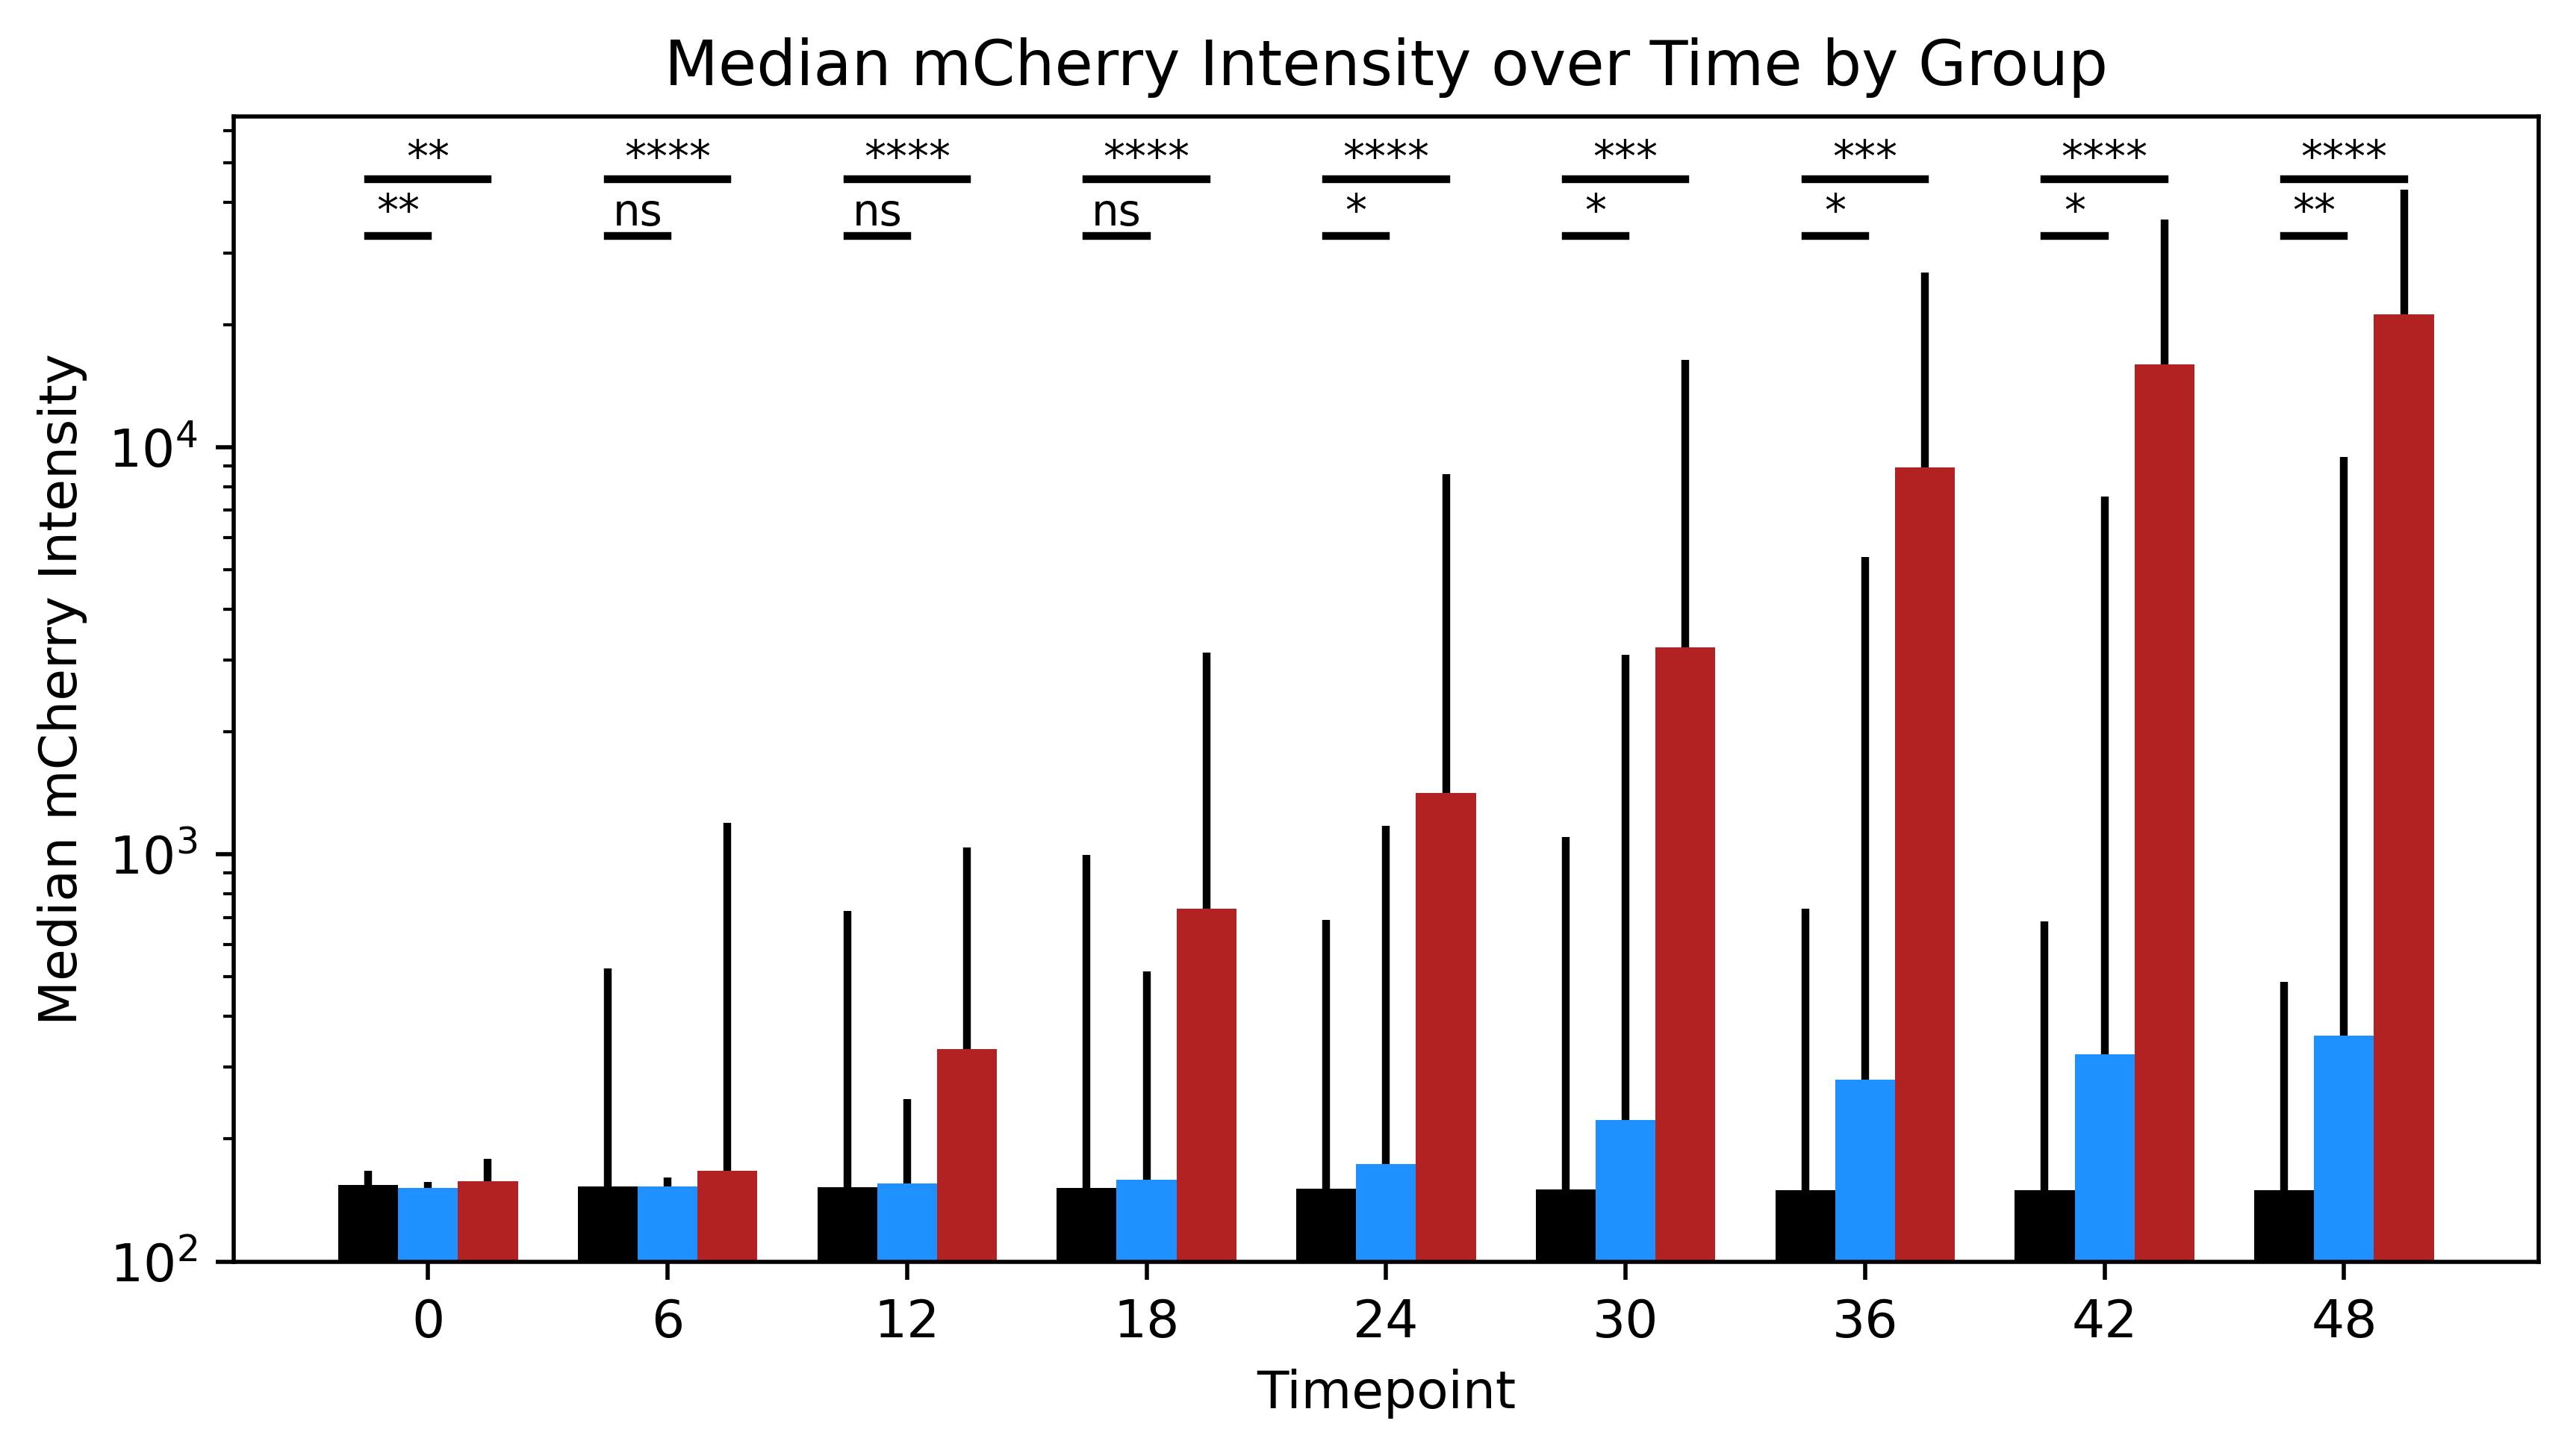

In [85]:
line_mcherry_df = mcherry_tmp_df.copy()
line_mcherry_df = line_mcherry_df.loc[(line_mcherry_df['construct'] != 'mTQ2') & (line_mcherry_df['construct'] != 'mNG')]

line_mcherry_df['timepoint'] = line_mcherry_df['timepoint']* 6 
# Set up the figure
line_mcherry_df = processing_cleanup.infection_false_positives(line_mcherry_df)
line_mcherry_df = processing_cleanup.infection_parameters(line_mcherry_df, lower_cutoff=0.849, upper_cutoff=0.85)
line_mcherry_df = line_mcherry_df.loc[line_mcherry_df['experimentparameter']!= 'mixed_population']
growth_only = line_mcherry_df.loc[line_mcherry_df['experimentcondition'] == 'Growth']
growth_only['experimentparameter'] = 'Growth'
infected_only = line_mcherry_df.loc[line_mcherry_df['experimentcondition'] != 'Growth']
new_mcherry_df = pd.concat([growth_only, infected_only])
fig, ax = plt.subplots(figsize=(7, 4))

# Extract unique parameters and timepoints
experimentparameters = new_mcherry_df ['experimentparameter'].unique()
timepoints = sorted(new_mcherry_df ['timepoint'].unique())

# Bar plot settings
x = np.arange(len(timepoints))  # X locations for the timepoints
width = 0.25  # Width of the bars
n_groups = len(experimentparameters)
colors = ['k', 'dodgerblue', 'firebrick']  # Just to make it look nicer

# Plotting each experimentparameter group
for i, param in enumerate(experimentparameters):
    # Filter and aggregate for current group
    group_df = new_mcherry_df[new_mcherry_df['experimentparameter'] == param]
    if param == 'Growth':
        comparison_group = group_df.groupby(['timepoint', 'construct'], as_index=False)['mCherry_intensity_mean'].median()
    else:
        variable_group = group_df.groupby(['timepoint', 'construct'], as_index=False)['mCherry_intensity_mean'].median()
        signi_dict = {}
        for len_indexer, time in enumerate(timepoints):
            current_comp = comparison_group.loc[comparison_group['timepoint']== time]
            current_var = variable_group.loc[variable_group['timepoint']== time]
            list_comp_values = current_comp['mCherry_intensity_mean'].to_list()
            list_var_values = current_var['mCherry_intensity_mean'].to_list()
            ttest, pvalue = stats.ttest_ind(list_comp_values, list_var_values)
            star_value = set_pvalue(pvalue)
            signi_dict[len_indexer] = star_value
    
    medians = group_df.groupby('timepoint')['mCherry_intensity_mean'].median().reindex(timepoints).fillna(0)

    central_vals = group_df.groupby('timepoint')['mCherry_intensity_mean'].median().reindex(timepoints).fillna(0)
    upper_errors = group_df.groupby('timepoint')['mCherry_intensity_mean'].std().reindex(timepoints).fillna(0)
    # Create asymmetric error bars: no lower bar
    yerr = [np.zeros_like(upper_errors), upper_errors.values]
    
    offset = (i - n_groups/2) * width + width/2
    if param == 'Growth':
        growth_offset_list = x + offset
    if param != 'Growth':
        for key, item in signi_dict.items():
            y_offset = 60000 - (25000/i)
            x_pos = key + offset

            #plot horizontal lines
            growth_pos = growth_offset_list[key]
            x_coord = [growth_pos, x_pos]
            y_coord = [y_offset-2000, y_offset-2000]
            ax.plot(x_coord, y_coord, 'k-')

            star_xplot = x_pos - (x_pos-growth_pos)/2
            ax.text(star_xplot, y_offset, item, ha='center', fontsize='small')

            
            
        
    ax.bar(x + offset, central_vals, yerr=yerr, width=width, label=param,
           color=colors[i % len(colors)], capsize=0)
    ax.set_ylim([100, 65000])
    ax.set_yscale('log')

# Formatting
ax.set_xlabel('Timepoint')
ax.set_ylabel('Median mCherry Intensity')
ax.set_title('Median mCherry Intensity over Time by Group')
ax.set_xticks(x)
ax.set_xticklabels(timepoints)
#ax.legend(title='Experiment Group')
plt.tight_layout()

plt.savefig(r'D:\OneDrive\Virus\Paper1\Paper1_figures\Violin_figures\infection_barplot_figure_percentile-top15-bottom85.png', format='png', bbox_inches='tight')

In [ ]:
#basal cell map
import seaborn as sns
N=12

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.YlOrRd(np.linspace(0.8, 0.25, N)))
basal_cell_df = recom_df
basal_cell_df = basal_cell_df.loc[(basal_cell_df['timepoint'] == 1) & (basal_cell_df['experimentparameter'] ==  'Growth')]
GS32_0 = GS32.loc[(GS32['timepoint'] == 1) & (GS32['experimentparameter'] ==  'Growth')]

basal_generator = basal_cell_df.groupby(['construct'], observed=True)

for index, df_container in enumerate(basal_generator):
    basal_df = df_container[1]
    print(len(basal_df))
    position = index +1
    sns.violinplot(basal_df, x='construct', y='Efret')
gs32_mean = GS32_0['Efret'].mean()

plt.axhline(gs32_mean, linestyle='--', c='k')
plt.savefig(r'D:/Patrick/basal_violin_microscope.svg', format='svg', bbox_inches='tight')